### Hugo Englund | 2020-11-27


# Laboration 3: Part X
## Outline
The aim of this labarotaion is to analyze the Fashion MNIST dataset by transfer learning, through the following steps:
1. Import the pretrained Xception model from Keras.
2. Scale the images to be applicable in the model.
3. Modify the layers in the model, as well as adding layers to adjust the model to the given classification problem.
4. Train and the test the modified Xception model.



#### Import relevant packages

In [ ]:
# import relevant packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

print(tf.__version__)

2.3.0


#### (Performance plot function)

In [ ]:
# plots accuracy and loss for training and validation, respectively
def plot_performance(history):
  # plot accuracy during training and validation
  plt.plot(history.history["accuracy"], label="Training\naccuracy")
  plt.plot(history.history["val_accuracy"], label="Validation\naccuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.ylim([0.5, 1])
  plt.legend(loc="best")
  plt.title("Training and validation accuracies")
  plt.grid(b=True)
  plt.show()

  # plot loss during training and validation
  plt.plot(history.history["loss"], label="Training\nloss")
  plt.plot(history.history["val_loss"], label='Validation\nloss')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.ylim([0, 0.5])
  plt.legend(loc="best")
  plt.title("Training and validation losses")
  plt.grid(b=True)
  plt.show()
  return

#### Import the Fashion MNIST data set

In [ ]:
# fetch data
fashion_mnist = tf.keras.datasets.fashion_mnist

# Save class names since they are not included in the imported data set
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# load data and split to train and test sets
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#### Data preparation
Before the modelling, we prepare the data by:
1. Scaling the images to at least 32x32 pixels since it is the smallest dimension applicable in VGG16.
2. Adding another dimension to the images as the RGB-channel, required in the model.
3. Verifying that the image scaling went correctly by plotting some images and investigating their dimensions.
4. Normalizing the data to a range between 0 and 1, in order for the features in each image to be in a common scale.
5. Converting the labels to one-hot encoded vectors since we have multiple outputs in the model.

In [ ]:
# define desired dimension of scaled images
# 71x71 is choosen since it is the smallest possible
DIM = (71, 71)

# scale images to desired size and add RGB-channels, e.g. 71x71x3
train_images = np.array([cv2.cvtColor(cv2.resize(img, DIM), cv2.COLOR_GRAY2BGR) for img in train_images])
test_images = np.array([cv2.cvtColor(cv2.resize(img, DIM), cv2.COLOR_GRAY2BGR) for img in test_images])

In [ ]:
# check dimension of train and test images
print("Dimension of scaled images:")
print("Training images: {}".format(train_images.shape))
print("Test images: {}".format(test_images.shape))

Dimension of scaled images:
Training images: (60000, 71, 71, 3)
Test images: (10000, 71, 71, 3)


#### Normalize images and convert labels


In [ ]:
from keras.utils.np_utils import to_categorical 
# normalize image pixels
train_images, test_images = train_images / 255.0, test_images / 255.0

# convert labels to one-hot encoded vectors
train_labels, test_labels = to_categorical(train_labels, num_classes=10), to_categorical(test_labels, num_classes=10)

#### Import the pretrained Xception model


In [ ]:
# import pretrained model
xcep = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(DIM[0], DIM[0], 3),
)

# make the imported layers nontrainable
xcep.trainable = False

# summarize the model
xcep.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 71, 71, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

#### Find where the entry flow ends
It is necessary to remove some layers in the Xception in order to reduce the complexity of the model since our problem is considered "easier" than what Xception is designed for.

As discussed previously, in part A and B, our images may not be that suitable for models pretrained on the ImageNet data since it differ considerably from our images. Therefore, only the entry flow is kept in the modified Xception model. I believe that keeping the middle flow in the model would overcomplicate the model in relation to our problem. Instead of improving the performance of the model, it would likely prolong training time without any payoff in accuracy. 

In [ ]:
# find index for the first layer in the middle flow
# i.e., index fo the layer named "block5_sepconv1_act"
for idx in range(len(xcep.layers)):
    if xcep.layers[idx].name == 'block5_sepconv1_act':
        stopping_index = idx
        break
print(stopping_index)

36


#### Modify the Xception model 
Modify the pretrained model by removing all existing layers beyond the entry flow, and adding additional dense layers, with regularization, suitable for our problem. More specifically:

1. Pretrained Xception model with only the entry flow.
2. Additonal, trainable dense layers with ReLu-activation function and regularization corresponding to batch normalization and dropout of rate 0.5:
    - 4096 units
    - 4096 units
    - 2048 units
    - 1024 units
    - 516 units
    - 516 units

3. Softmax activation with 10 units.

This is done by Keras functional API in which we chain layer calls to create a modified model.

In [ ]:
from tensorflow.keras import layers
from keras.models import Model

# reduce the model by removing all layers beyond "block5_sepconv1_act"
xcep_reduced = Model(inputs=xcep.input, outputs=xcep.layers[-(len(xcep.layers) - stopping_index + 3)].output)

# add custom layers to the reduced model
flatten = layers.Flatten()(xcep_reduced.output)

# dense layer 1
x = layers.Dense(4096, activation='relu')(flatten)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.50)(x)

# dense layer 2
x = layers.Dense(4096, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.50)(x)

# dense layer 3
x = layers.Dense(2048, activation='relu')(x) 
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.50)(x)

# dense layer 4
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.50)(x)

# dense layer 5
x = layers.Dense(516, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.50)(x)

# dense layer 6
x = layers.Dense(516, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.50)(x)

# activation layer
out = layers.Dense(10, activation='softmax')(x)

# build the modified model
xcep_mod = Model(inputs=xcep.input, outputs=out)

xcep_mod.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 71, 71, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

#### Compile the modified model
We use the Adam optimizer with a learning rate of 0.001.

In [ ]:
from keras.optimizers import Adam

# define optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model 
xcep_mod.compile(
    optimizer = optimizer,
    loss = "categorical_crossentropy", 
    metrics=["accuracy"]
)

#### Train the modified model
The validation split is set to the fraction corresponding to exactly 10000 images. Thus, we get an approximate 70`/`15`/`15%-split between training, testing and validation images, respectively. 

In addition, early stopping with a patience of two epochs is used in the model, which is that if the validation loss is no longer decreasing in four consecutive epochs, the training is terminated. This used to prevent excessive training times and foremost overfitting. The callback to reduction of the learning rate is also used in this model, which reduces the learning rate if the validation loss has not decreased between two epochs.

We use 30 epochs and a batch size of 100.

In [ ]:
# define epochs and batch size
epochs = 30
batch_size = 100

# callback: early stopping 
early_stop = tf.keras.callbacks.EarlyStopping(patience=2, verbose=1)

# callback: reduced learning rate on plateau
reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=1,
    min_lr=0
)

# fit the model
history = xcep_mod.fit(
    train_images,
    train_labels,
    batch_size=batch_size,
    validation_split=1/6,
    epochs=epochs,
    callbacks=[early_stop, reduce_learning]
)

Epoch 1/30
500/500 [==============================] - 11s 22ms/step - loss: 0.7087 - accuracy: 0.7561 - val_loss: 0.2854 - val_accuracy: 0.8986
Epoch 2/30
500/500 [==============================] - 11s 21ms/step - loss: 0.3274 - accuracy: 0.8900 - val_loss: 0.2752 - val_accuracy: 0.9035
Epoch 3/30
500/500 [==============================] - 11s 21ms/step - loss: 0.2754 - accuracy: 0.9066 - val_loss: 0.2171 - val_accuracy: 0.9214
Epoch 4/30
499/500 [============================>.] - ETA: 0s - loss: 0.2503 - accuracy: 0.9145
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
500/500 [==============================] - 11s 21ms/step - loss: 0.2504 - accuracy: 0.9145 - val_loss: 0.2195 - val_accuracy: 0.9246
Epoch 5/30
500/500 [==============================] - 11s 21ms/step - loss: 0.1958 - accuracy: 0.9337 - val_loss: 0.1752 - val_accuracy: 0.9387
Epoch 6/30
499/500 [============================>.] - ETA: 0s - loss: 0.1797 - accuracy: 0.9388
Epoch 00006: Reduc

#### Evaluate the model
The model is evaluated by analyzing the curves of loss and accuracy in both training and validation. 

Ideally, the curves of training and validation should be more or less identical in both accuracy and loss towards the last epochs, in order to obtain a generalized model.

However, there can be cases where the validation loss is consistently greater than the training loss. This indicates underfitting. 

On the contrary, if the validation loss follows the training loss and then starts to deviate by increasing, we are overfitting.

There could also be cases where the validation loss is consistently lesser than the training loss. There are three main reasons for this:
1. Regularization is applied during training, but not during validation.
2. Training loss is computed during each epoch, while validation loss is computed after each epoch. 
3. The validation set is "easier" than the training set.

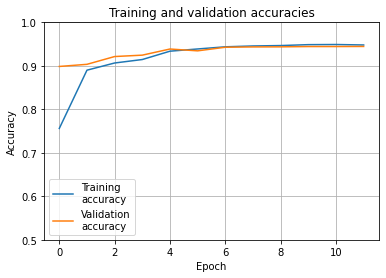

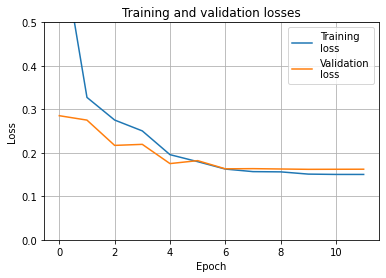

In [ ]:
# analyze training and validation accuracy/loss
plot_performance(history)

#### Test the modified model

In [ ]:
# test the model and print out the results
test_loss, test_acc = xcep_mod.evaluate(test_images, test_labels, verbose=0)
print("Test loss: {0:.{1}}".format(test_loss, 4))
print("Test accuracy: {0:.{1}}".format(test_acc, 4))

Test loss: 0.1818
Test accuracy: 0.94


#### Model conclusion
Form the accuracy and loss plots, it can be seen that validation and accuracy loss differs only slightly from those in the training towards the last epochs. Even though there is a deviation, the validation loss did not start to increase which indicates that the fit can be considered good, nevertheless.

The test accuracy is \~94% which is highest achieved among all produced models so far. The test loss of \~0.182 is the lowest we have obtained compared to previous models.

#### Discussion
Accuracywise, this is the best model we have obtained compared to all previously made models. Compared to the modified VGG16 this model had:
- 103,595,810 parameters of which 948,936 were nontrainable. This is more than twice as many as in the VGG16.
- a larger batch size of 100, compared to 50 in VGG16.
- the Adam optimizer with a learning rate of 0.001, i.e., the same as in VGG16.
- the same callbacks in terms of early stopping and reduced learning rate.
- the same set of additional layers as in VGG16.
- a higher accuracy of 94%, compared to \~92.7% in VGG16.

Among the hyperparameters and the "custom" dense layers, it is only the batch size that differ between the modified Xception and VGG16. Hence, we can argue that the models are, more or less, comparable. On one hand, the underlying pretrained model in each case have been trained on the same ImageNet data. On the other hand, their corresponding architecture differ widely. We can also note that results probably would be different if we had incorporated more (or fewer) layers of the pretrained models.

However, by the current modifications of the models, we have shown that Xception performs considerably better than VGG16. This can be due to the fact that Xception utilizes separable depthwise convolutions, compared to VGG16, that has "ordinary" convolutions. Another aspect is the regularization used in each model. Xception has batch normalization between each layer, while VGG16 has weight decay and dropout in the fully-connected layers (not considered in this laboration). 

With respect to these factors (among other structural differences), there is support that the Xception architecture is better for the Fashion MNIST classification problem. Although Xception is favorable with the modifications made in this laboration, an interesting extension of the comparison would be to utilize the full pretrained models. As well as letting some of the pretrained layers in Xception be trainable, as we did with VGG16 in part B. 

Lastly, we can distinguish between the modified Xception and the previous models from laboration 1 and 2. The main difference is the size and depth of models. I believe that my initial models were too small to get above 93% accuracy. Besides that, my initial models had an architecture inspired by VGG16, which, as shown here, does not perform as well as Xception. Therefore, a structural change as well as an introduction of separable convolutions are to consider in further development of my previous Fashion MNIST classifiers. 

